# Capstone Project - The Battle of the Neighborhoods



## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem of knowledge of neighborhood for real estate agent<a name="introduction"></a>

Real estate agents compete from same customer and customers want to find best home and also best neighborhood for their family. Deep knowledge of area and neighborhood brings advantage in competition. From real estate point of view there is battle of neighborhoods. 

Nobody can remenber or know all venues in Helsinki Finland area and so cannot promote all venues and categories which can found through Foursquare API. We would like to provide targeted information near property to sold for real estate agents. We would also cluster and categorise living areas to quicly tell in which category of property belongs and what are unique charasteristics of that area for example good parks and cafeterias. This makes difference when agent has sales meeting with owner. This information can be even crucial when families deciding where they are going to move and buy new home. 



## Import all needed libraries

In [89]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # 
import folium # map rendering library

#Lib for html handling
from lxml import html

print('Libraries imported.')

Libraries imported.


## Data <a name="data"></a>

Based on definition of our problem, factors that will help real estate agent are:
* All venues of neighborhood
* Top venue categoeries in neighborhood
* Overall style for example cafes and parks


Following data sources will be needed to generate the required information:
* Wikipedia page of Helsinki neighborhood including 
* All venues or neigborhood area through Foursqueare API
* Geolocator to get coordinates of neighborhoods

We will use the **explore** function to get the most common venue categories in each neighborhood of Helsinki. We will also cluster neighborhoods to give similarity information to end customer. 

In [90]:
#Fetch wikipedia page as html
url = 'https://fi.wikipedia.org/wiki/Helsingin_alueellinen_jako'
pageContent=requests.get(url)
neighborhood_html = html.fromstring(pageContent.content)

In [91]:
# define the dataframe columns
column_names = ['Neighborhood', 'lat', 'lng'] 
df = pd.DataFrame(columns=column_names)
#Get table rows of Helsinki Neigborhoods with xpath
rows = neighborhood_html.xpath('//*[@id="mw-content-text"]/div/table[2]/tbody/tr')

for row in rows:
    #Append dataframe with variable values
    children = row[0].getchildren()
    
    for child in children:
        if child.tag == 'ul':
            for li in child[0]:
                #print('Suppea')
                df = df.append({'Neighborhood': li.text}, ignore_index=True)
        else:
            df = df.append({'Neighborhood': child.text}, ignore_index=True)
           
df.head()

Neighborhood  lat  lng
0      Kruununhaka  NaN  NaN
1           Kluuvi  NaN  NaN
2  Kaartinkaupunki  NaN  NaN
3           Kamppi  NaN  NaN
4        Punavuori  NaN  NaN

In [92]:
# Dataframe contains all Helsinki neighborhoods or city areas which are in small capital city same thing.
df.head()

Neighborhood  lat  lng
0      Kruununhaka  NaN  NaN
1           Kluuvi  NaN  NaN
2  Kaartinkaupunki  NaN  NaN
3           Kamppi  NaN  NaN
4        Punavuori  NaN  NaN

### Featch average housing price in Helsinki neighborhoods

In [93]:
#Fetch housing price page as html
price_url = 'https://www.asuntojenhinnat.fi/myytyjen-asuntojen-tilastot/kunta/Helsinki/'
pricePageContent=requests.get(price_url)
price_html = html.fromstring(pricePageContent.content)


In [94]:
# define the dataframe columns
price_column_names = ['Neighborhood', 'Price'] 
df_price = pd.DataFrame(columns=price_column_names)

#Create lists for hood and price
hood = []
price = []

#Get table rows of Helsinki Neigborhoods with xpath
price_rows = price_html.xpath('//*[@id="main"]/section[4]/div/div/table/tbody/tr')

for row in price_rows:
    #Append dataframe with variable values
    hood.append(row[1].text_content())
    price.append(row[2].text)

df_price['Neighborhood'] = hood
df_price['Price'] = price
df_price.head()

Neighborhood Price
0      Kaivopuisto  8474
1  Kaartinkaupunki  8205
2             Eira  8051
3       Ruoholahti  7595
4        Punavuori  7481

In [95]:
#Merge pricing data to Dataframe
df = pd.merge(df, df_price, on='Neighborhood')
df.head()

Neighborhood  lat  lng Price
0      Kruununhaka  NaN  NaN  6946
1  Kaartinkaupunki  NaN  NaN  8205
2        Punavuori  NaN  NaN  7481
3             Eira  NaN  NaN  8051
4      Katajanokka  NaN  NaN  6134

#### Use geopy library to get the latitude and longitude values of Helsinki

In [96]:
# Let's get first coordinates of Helsinki area and see that data is correct
address = 'Helsinki, FI'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Helsinki City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Helsinki City are 60.1674086, 24.9425683.


In [97]:
#Create lists for lat and long
lat = []
lng = []

#Loop through all neigborhoods in Helsinki
for adr in df['Neighborhood']:
    
    #Use geolocator to get coordinates of neigborhoods
    loc = geolocator.geocode(adr)
    #Append coordinates to lists
    lat.append(loc.latitude)
    lng.append(loc.longitude)

#Map coordinate lists to data frame 
df['lat'] = lat
df['lng'] = lng



In [98]:
#Neighborhoods with coordinates and m2 pricing
df.head()

Neighborhood        lat        lng Price
0      Kruununhaka  60.172870  24.954733  6946
1  Kaartinkaupunki  60.165214  24.947222  8205
2        Punavuori  60.161237  24.936505  7481
3             Eira  60.156191  24.938375  8051
4      Katajanokka  60.166975  24.968151  6134

### Foursquare API
Opened. sandbox for Coursera project. In this section we generate url for fetching venue data for Helsinki neigborhoods

In [99]:
CLIENT_ID = 'XDSVHHZ0OH2OITHZSB5MJSEHSUVR5J3CYY5EOHOQTV550IQ1' # your Foursquare ID
CLIENT_SECRET = '5MNXPTBQ4GVTH0KMT0H0UKX00KYCEDLTI0XLT5BKJGME4AO3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XDSVHHZ0OH2OITHZSB5MJSEHSUVR5J3CYY5EOHOQTV550IQ1
CLIENT_SECRET:5MNXPTBQ4GVTH0KMT0H0UKX00KYCEDLTI0XLT5BKJGME4AO3


In [100]:
#Get Kruunuhaka or City Center venues

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=XDSVHHZ0OH2OITHZSB5MJSEHSUVR5J3CYY5EOHOQTV550IQ1&client_secret=5MNXPTBQ4GVTH0KMT0H0UKX00KYCEDLTI0XLT5BKJGME4AO3&v=20180605&ll=60.1728702,24.9547326&radius=500&limit=100'

In [101]:
results = requests.get(url).json()

# Methodology <a name="methodology"></a>

We are providing characteristic information about Helsinki neighborhoods combining venue and pricing information and making clusters of neighborhoods. 

First phase for project was that: 
* We collected all neighborhoods with subneighborhoods. 
* Added coordinates to all neighborhoods
* Added average m2 pricing to all neighborhoods, when data was available

Second phase was make analysis
* We 


# Analysis

In [102]:
#Check that coordites work correctly
neighborhood_latitude = df.loc[0, 'lat'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'lng'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Kruununhaka are 60.1728702, 24.9547326.


In [103]:
# create map of Helsinki using latitude and longitude values
Helsinki_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for index, row in df.iterrows():

    adr = row['Neighborhood']
    lat = row['lat']
    lng = row['lng']

    label = '{}'.format(adr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Helsinki_map)  

Helsinki_map

### Functions for data preparation and analysis

In [104]:
#Function to Get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [105]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [106]:
# Function for most common venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [107]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name               categories        lat        lng
0  Restaurant Ask  Scandinavian Restaurant  60.172366  24.955864
1     Korea House        Korean Restaurant  60.172910  24.956436
2        Cafe LOV                     Café  60.171284  24.956623
3        Bei Fang       Chinese Restaurant  60.171602  24.953990
4       Papu Cafe                     Café  60.173040  24.956453

In [108]:
all_helsinki_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['lat'], longitudes=df['lng'])

Kruununhaka
Kaartinkaupunki
Punavuori
Eira
Katajanokka
Kaivopuisto
Sörnäinen
Kallio
Etu-Töölö
Taka-Töölö
Ruskeasuo
Länsi-Pasila
Ruoholahti
Vallila
Käpylä
Etelä-Haaga
Munkkiniemi
Lauttasaari
Konala
Kannelmäki
Länsi-Pakila
Paloheinä
Viikki
Malmi
Tapaninvainio
Siltamäki
Suurmetsä
Puistola
Kulosaari
Herttoniemi
Länsi-Herttoniemi
Tammisalo
Vartioharju
Pajamäki
Mellunkylä
Kontula
Laajasalo


In [109]:
all_helsinki_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude           Venue  \
0  Kruununhaka               60.17287               24.954733  Restaurant Ask   
1  Kruununhaka               60.17287               24.954733     Korea House   
2  Kruununhaka               60.17287               24.954733        Cafe LOV   
3  Kruununhaka               60.17287               24.954733        Bei Fang   
4  Kruununhaka               60.17287               24.954733       Papu Cafe   

   Venue Latitude  Venue Longitude           Venue Category  
0       60.172366        24.955864  Scandinavian Restaurant  
1       60.172910        24.956436        Korean Restaurant  
2       60.171284        24.956623                     Café  
3       60.171602        24.953990       Chinese Restaurant  
4       60.173040        24.956453                     Café

In [110]:
hood_venue = all_helsinki_venues[['Neighborhood', 'Venue']].copy()

In [111]:
hood_venues = hood_venue.groupby(['Neighborhood']).size().reset_index(name='Venues')
hood_venues.head()

Neighborhood  Venues
0             Eira      37
1      Etelä-Haaga      12
2        Etu-Töölö      36
3      Herttoniemi      34
4  Kaartinkaupunki     100

In [112]:
#Merge number of venues to Dataframe
df = pd.merge(df, hood_venues, on='Neighborhood')
df.head()

Neighborhood        lat        lng Price  Venues
0      Kruununhaka  60.172870  24.954733  6946      75
1  Kaartinkaupunki  60.165214  24.947222  8205     100
2        Punavuori  60.161237  24.936505  7481     100
3             Eira  60.156191  24.938375  8051      37
4      Katajanokka  60.166975  24.968151  6134      36

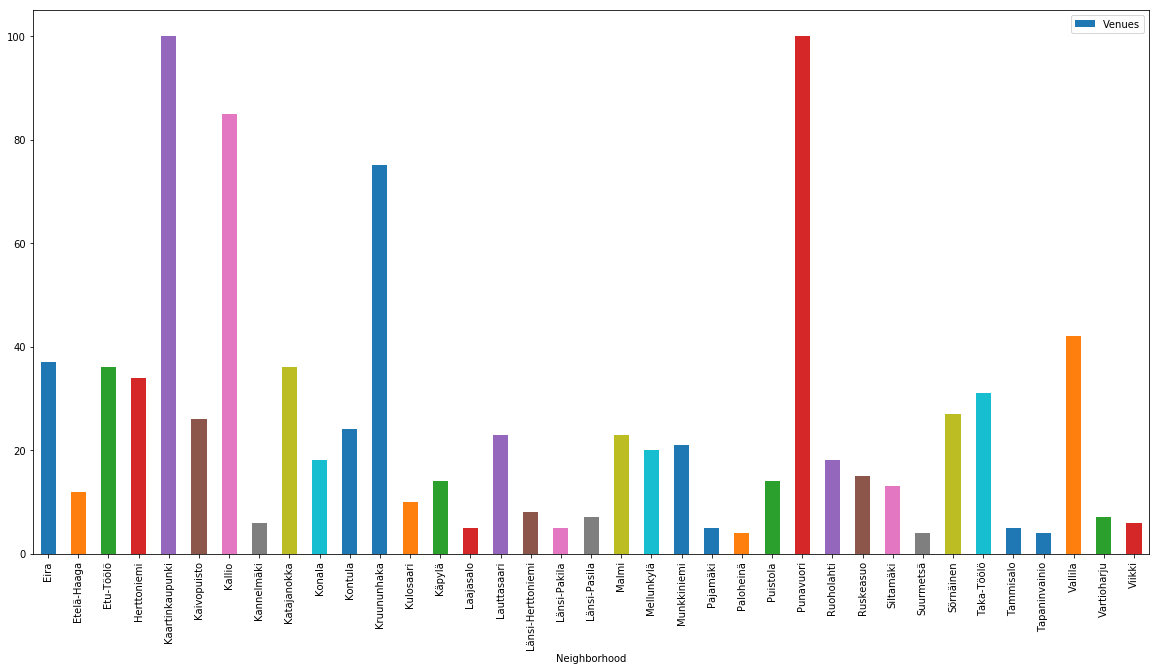

In [113]:
hood_venues.sort_values(by=['Venues'])
hood_venues.plot.bar(x='Neighborhood', y='Venues', rot=90,figsize=(20,10))

In [114]:
# one hot encoding
helsinki_onehot = pd.get_dummies(all_helsinki_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
helsinki_onehot['Neighborhood'] = df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [helsinki_onehot.columns[-1]] + list(helsinki_onehot.columns[:-1])
downtown_onehot = helsinki_onehot[fixed_columns]

helsinki_onehot.head()



African Restaurant  American Restaurant  Art Gallery  Art Museum  \
0                   0                    0            0           0   
1                   0                    0            0           0   
2                   0                    0            0           0   
3                   0                    0            0           0   
4                   0                    0            0           0   

   Arts & Crafts Store  Asian Restaurant  Auditorium  Automotive Shop  \
0                    0                 0           0                0   
1                    0                 0           0                0   
2                    0                 0           0                0   
3                    0                 0           0                0   
4                    0                 0           0                0   

   BBQ Joint  Badminton Court  Bagel Shop  Bakery  Bar  Bay  Beach  Beer Bar  \
0          0                0           0       0    0    0      0         0   
1          0                0           0       0    0    0      0         0   
2          0                0           0       0    0    0      0         0   
3          0                0           0       0    0    0      0         0   
4          0                0           0       0    0    0      0         0   

   Beer Garden  Bistro  Boat or Ferry  Bookstore  Boutique  Bowling Alley  \
0            0       0              0          0         0              0   
1            0       0              0          0         0              0   
2            0       0              0          0         0              0   
3            0       0              0          0         0              0   
4            0       0              0          0         0              0   

   Breakfast Spot  Brewery  Burger Joint  Burrito Place  Bus Station  \
0               0        0             0              0            0   
1               0        0             0              0            0   
2               0        0             0              0            0   
3               0        0             0              0            0   
4               0        0             0              0            0   

   Bus Stop  Cafeteria  Café  Canal  Candy Store  Cheese Shop  \
0         0          0     0      0            0            0   
1         0          0     0      0            0            0   
2         0          0     1      0            0            0   
3         0          0     0      0            0            0   
4         0          0     1      0            0            0   

   Chinese Restaurant  Clothing Store  Cocktail Bar  Coffee Shop  College Gym  \
0                   0               0             0            0            0   
1                   0               0             0            0            0   
2                   0               0             0            0            0   
3                   1               0             0            0            0   
4                   0               0             0            0            0   

   Community Center  Convenience Store  Costume Shop  Cultural Center  \
0                 0                  0             0                0   
1                 0                  0             0                0   
2                 0                  0             0                0   
3                 0                  0             0                0   
4                 0                  0             0                0   

   Dance Studio  Deli / Bodega  Department Store  Dessert Shop  Diner  \
0             0              0                 0             0      0   
1             0              0                 0             0      0   
2             0              0                 0             0      0   
3             0              0                 0             0      0   
4             0              0                 0             0      0   

   D

In [115]:
helsinki_grouped = helsinki_onehot.groupby('Neighborhood').mean().reset_index()
helsinki_grouped.head()

Neighborhood  African Restaurant  American Restaurant  Art Gallery  \
0             Eira                   0                    0            0   
1      Etelä-Haaga                   0                    0            0   
2        Etu-Töölö                   0                    0            0   
3      Herttoniemi                   0                    0            0   
4  Kaartinkaupunki                   0                    0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Auditorium  \
0           0                    0                 0           0   
1           0                    0                 0           0   
2           0                    0                 0           0   
3           0                    0                 0           0   
4           0                    0                 0           0   

   Automotive Shop  BBQ Joint  Badminton Court  Bagel Shop  Bakery  Bar  Bay  \
0                0          0                0           0       0    0    0   
1                0          0                0           0       0    0    0   
2                0          0                0           0       0    0    0   
3                0          0                0           0       0    0    0   
4                0          0                0           0       0    0    0   

   Beach  Beer Bar  Beer Garden  Bistro  Boat or Ferry  Bookstore  Boutique  \
0      0         0            0       0              0          0         0   
1      0         0            0       0              0          0         0   
2      0         0            0       0              0          0         0   
3      0         0            0       0              0          0         0   
4      0         0            0       0              0          0         0   

   Bowling Alley  Breakfast Spot  Brewery  Burger Joint  Burrito Place  \
0              0               0        0             0              0   
1              0               0        0             0              0   
2              0               0        0             0              0   
3              0               0        0             0              0   
4              0               0        0             0              0   

   Bus Station  Bus Stop  Cafeteria  Café  Canal  Candy Store  Cheese Shop  \
0            0         0          0     0      0            0            0   
1            0         0          0     0      0            0            0   
2            0         0          0     0      0            0            0   
3            0         0          0     0      0            0            0   
4            0         0          0     0      0            0            0   

   Chinese Restaurant  Clothing Store  Cocktail Bar  Coffee Shop  College Gym  \
0                   1               0             0            0            0   
1                   0               0             0            0            0   
2                   0               0             0            0            0   
3                   0               0             0            0            0   
4                   0               0             0            0            0   

   Community Center  Convenience Store  Costume Shop  Cultural Center  \
0                 0                  0             0                0   
1                 0                  0             0                0   
2                 0                  0             0                0   
3                 0                  0             0                0   
4                 0                  0             0                0   

   Dance Studio  Deli / Bodega  Department Store  Dessert Shop  Diner  \
0             0              0                 0             0      0   
1             0              0                 0             0      0   
2             0              0                 0             0      0   
3             0              0                 0    

In [116]:
#Get 10 top venues of neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = helsinki_grouped['Neighborhood']

for ind in np.arange(helsinki_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(helsinki_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood    1st Most Common Venue 2nd Most Common Venue  \
0             Eira       Chinese Restaurant                   Zoo   
1      Etelä-Haaga                Speakeasy                   Zoo   
2        Etu-Töölö  Scandinavian Restaurant                   Zoo   
3      Herttoniemi                  Theater                   Zoo   
4  Kaartinkaupunki        Korean Restaurant                   Zoo   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0             Gastropub         Garden Center                Garden   
1             Gastropub         Garden Center                Garden   
2           Flower Shop         Garden Center                Garden   
3                  Food           Gas Station         Garden Center   
4           Flower Shop           Gas Station         Garden Center   

    6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
0  Furniture / Home Store       French Restaurant              Fountain   
1  Furniture / Home Store       French Restaurant              Fountain   
2  Furniture / Home Store       French Restaurant              Fountain   
3                  Garden  Furniture / Home Store     French Restaurant   
4                  Garden  Furniture / Home Store     French Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0                Forest             Food Truck  
1                Forest             Food Truck  
2                Forest             Food Truck  
3              Fountain                 Forest  
4              Fountain                 Forest

In [117]:
#Check shape
helsinki_grouped.shape

(37, 196)

In [118]:
all_helsinki_venues.shape

(920, 7)

In [119]:
#Five top venues of Helsinki neighborhoods
num_top_venues = 5

for hood in df['Neighborhood']:
    print("----"+hood+"----")
    temp = helsinki_grouped[helsinki_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Kruununhaka----
                     venue  freq
0  Scandinavian Restaurant   1.0
1       African Restaurant   0.0
2                Pet Store   0.0
3                Nightclub   0.0
4  North Indian Restaurant   0.0


----Kaartinkaupunki----
                     venue  freq
0        Korean Restaurant   1.0
1       African Restaurant   0.0
2                Pet Store   0.0
3                Nightclub   0.0
4  North Indian Restaurant   0.0


----Punavuori----
                     venue  freq
0                     Café   1.0
1       African Restaurant   0.0
2                   Museum   0.0
3                Nightclub   0.0
4  North Indian Restaurant   0.0


----Eira----
                     venue  freq
0       Chinese Restaurant   1.0
1       African Restaurant   0.0
2                   Museum   0.0
3                Nightclub   0.0
4  North Indian Restaurant   0.0


----Katajanokka----
                     venue  freq
0                     Café   1.0
1       African Restaurant   0.0
2     

# Machine learning and Cluster Neighborhoods

In [120]:
# set number of clusters
kclusters = 5

helsinki_grouped_clustering = helsinki_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(helsinki_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 1, 0, 0, 0, 0, 3, 0], dtype=int32)

In [121]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

helsinki_merged = df

# merge helsinki_grouped with helsinki_data to add latitude/longitude for each neighborhood
helsinki_merged = helsinki_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

helsinki_merged.head() # check the last columns!

Neighborhood        lat        lng Price  Venues  Cluster Labels  \
0      Kruununhaka  60.172870  24.954733  6946      75               4   
1  Kaartinkaupunki  60.165214  24.947222  8205     100               0   
2        Punavuori  60.161237  24.936505  7481     100               3   
3             Eira  60.156191  24.938375  8051      37               0   
4      Katajanokka  60.166975  24.968151  6134      36               3   

     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0  Scandinavian Restaurant                   Zoo           Flower Shop   
1        Korean Restaurant                   Zoo           Flower Shop   
2                     Café                   Zoo             Gastropub   
3       Chinese Restaurant                   Zoo             Gastropub   
4                     Café                   Zoo             Gastropub   

  4th Most Common Venue 5th Most Common Venue   6th Most Common Venue  \
0         Garden Center                Garden  Furniture / Home Store   
1           Gas Station         Garden Center                  Garden   
2         Garden Center                Garden  Furniture / Home Store   
3         Garden Center                Garden  Furniture / Home Store   
4         Garden Center                Garden  Furniture / Home Store   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0       French Restaurant              Fountain                Forest   
1  Furniture / Home Store     French Restaurant              Fountain   
2       French Restaurant              Fountain                Forest   
3       French Restaurant              Fountain                Forest   
4       French Restaurant              Fountain                Forest   

  10th Most Common Venue  
0             Food Truck  
1                 Forest  
2             Food Truck  
3             Food Truck  
4             Food Truck

In [122]:
most_common_in_cluster = helsinki_merged[['Cluster Labels', '1st Most Common Venue']].copy()
most_common_in_cluster = most_common_in_cluster.groupby(['Cluster Labels', '1st Most Common Venue' ]).size().reset_index(name='Venues')
most_common_in_cluster

Cluster Labels          1st Most Common Venue  Venues
0                0                         Bakery       1
1                0                       Beer Bar       1
2                0                         Bistro       1
3                0                  Boat or Ferry       1
4                0                        Brewery       1
5                0             Chinese Restaurant       1
6                0                   Dessert Shop       1
7                0                    Event Space       1
8                0                     Food Truck       1
9                0              German Restaurant       1
10               0              Health Food Store       1
11               0                 History Museum       1
12               0                         Hostel       1
13               0            Indie Movie Theater       1
14               0                  Indie Theater       1
15               0              Korean Restaurant       1
16               0     Modern European Restaurant       1
17               0            Monument / Landmark       1
18               0                Organic Grocery       1
19               0                          Plaza       1
20               0                     Restaurant       1
21               0                 Scenic Lookout       1
22               0                      Speakeasy       1
23               0               Sushi Restaurant       1
24               0  Vegetarian / Vegan Restaurant       1
25               0          Vietnamese Restaurant       2
26               1                        Theater       2
27               2                    Coffee Shop       2
28               3                           Café       3
29               4        Scandinavian Restaurant       3

In [123]:
#Giving cluster names after analyzing data
cluster_name = {}
cluster_name[0] = "Lot of services"
cluster_name[1] = "Theater"
cluster_name[2] = "Coffee shop"
cluster_name[3] = "Cafe"
cluster_name[4] = "Scandinavian Restaurant"

# Results and discussion <a name="results"></a>

In [124]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, price in zip(helsinki_merged['lat'], helsinki_merged['lng'], helsinki_merged['Neighborhood'], helsinki_merged['Cluster Labels'],helsinki_merged['Price']):
    label = folium.Popup(str(poi) + ' Most of venue type: ' + str(cluster_name[cluster]) + '. Avg square price: ' + str(price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [125]:

helsinki_merged.set_index("Neighborhood", inplace=True)
helsinki_merged.head()

lat        lng Price  Venues  Cluster Labels  \
Neighborhood                                                          
Kruununhaka      60.172870  24.954733  6946      75               4   
Kaartinkaupunki  60.165214  24.947222  8205     100               0   
Punavuori        60.161237  24.936505  7481     100               3   
Eira             60.156191  24.938375  8051      37               0   
Katajanokka      60.166975  24.968151  6134      36               3   

                   1st Most Common Venue 2nd Most Common Venue  \
Neighborhood                                                     
Kruununhaka      Scandinavian Restaurant                   Zoo   
Kaartinkaupunki        Korean Restaurant                   Zoo   
Punavuori                           Café                   Zoo   
Eira                  Chinese Restaurant                   Zoo   
Katajanokka                         Café                   Zoo   

                3rd Most Common Venue 4th Most Common Venue  \
Neighborhood                                                  
Kruununhaka               Flower Shop         Garden Center   
Kaartinkaupunki           Flower Shop           Gas Station   
Punavuori                   Gastropub         Garden Center   
Eira                        Gastropub         Garden Center   
Katajanokka                 Gastropub         Garden Center   

                5th Most Common Venue   6th Most Common Venue  \
Neighborhood                                                    
Kruununhaka                    Garden  Furniture / Home Store   
Kaartinkaupunki         Garden Center                  Garden   
Punavuori                      Garden  Furniture / Home Store   
Eira                           Garden  Furniture / Home Store   
Katajanokka                    Garden  Furniture / Home Store   

                  7th Most Common Venue 8th Most Common Venue  \
Neighborhood                                                    
Kruununhaka           French Restaurant              Fountain   
Kaartinkaupunki  Furniture / Home Store     French Restaurant   
Punavuori             French Restaurant              Fountain   
Eira                  French Restaurant              Fountain   
Katajanokka           French Restaurant              Fountain   

                9th Most Common Venue 10th Most Common Venue  
Neighborhood                                                  
Kruununhaka                    Forest             Food Truck  
Kaartinkaupunki              Fountain                 Forest  
Punavuori                      Forest             Food Truck  
Eira                           Forest             Food Truck  
Katajanokka                    Forest             Food Truck

In [126]:
#Example of how real estate agent could fetch information by neighborhood when going to sales meeting
helsinki_merged.loc['Eira']

lat                                      60.1562
lng                                      24.9384
Price                                       8051
Venues                                        37
Cluster Labels                                 0
1st Most Common Venue         Chinese Restaurant
2nd Most Common Venue                        Zoo
3rd Most Common Venue                  Gastropub
4th Most Common Venue              Garden Center
5th Most Common Venue                     Garden
6th Most Common Venue     Furniture / Home Store
7th Most Common Venue          French Restaurant
8th Most Common Venue                   Fountain
9th Most Common Venue                     Forest
10th Most Common Venue                Food Truck
Name: Eira, dtype: object

## Discussion

Helsinki City is relatively small city so for effective data analysis we would need even more venues in Foursquare. Lot of neighborhoods have small amount of many kind of venues to offer people who want to move there. With adjusting k-means clustering we could have even better results. There is a big difference in average m2 housing price inside Helsinki and look’s that relates more other things that venues in neighborhood.  


# Conclusion <a name="conclusion"></a>

This kind of data analysis can be a helpful for a real estate agent and provides competitive advance quickly. Data should be used from app and Python code of this analysis should be provided as a microservice
